#### Scenario
A healthcare provider initiated an attrition analysis. They wish to know their current attrition rate and, if the rate is greater than ten percent, what are the contributing factors and potential solutions.

#### Problem Statement
How can we increase employee retention while minimizing costs?

In [9]:
import decimal
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple, Callable
from math import ceil, sqrt, modf

import pandas as pd
import seaborn as sns
from pandasql import sqldf
from statistics import median, stdev
from statsmodels.stats.weightstats import ztest

import utils

# Import file
filename = 'data/healthcare_attrition.csv'
raw_df = pd.read_csv(Path(utils.root(), filename), sep=',')

employed_df = raw_df.query("Attrition == 'No'")
attrited_df = raw_df.query("Attrition == 'Yes'")

### Samples
talk about how you got the sizes and got the sample. Used sample size calculator to determine sample size.

In [2]:
# sample_size = 100
def samples(*, is_employed: bool) -> pd.Series:
    population = None
    if is_employed:
        population = raw_df.query("Attrition == 'No'")
    else:
        population = raw_df.query("Attrition == 'Yes'")
    return lst

## Attrition Rate

In [11]:
# ATTRITION RATE
attrited_count = attrited_df.count()
total_employees = raw_df['Attrition'].count()

attrition_rate_percentage = round(attrition_count / total_employees, 2) * 100
print(f'The attrition rate is approximately {attrition_rate_percentage}%')

The attrition rate is approximately 12.0%


## Attrition by Age
Testing if age affects attrition. Found that the median age of the attrited group is lower than the employed group. Further analysis supports that age plays a significant role.


CHART
---------------


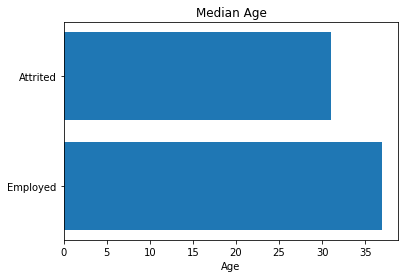


SUMMARY
---------------
pval                 0.000
cohens_d             0.715
ci_68_lower         22.000
ci_68_upper         40.000
empl_p_within_ci     0.660
attr_p_within_ci     0.730
empl_mean           37.000
attr_mean           31.000
dtype: float64


In [4]:
def age_test(empl_df: pd.DataFrame, attr_df: pd.DataFrame) -> pd.DataFrame:
    empl_age_df = empl_df['Age']
    attr_age_df = attr_df['Age']
    
    pval = utils.pval_unequal_stdev(empl_age_df, attr_age_df)
    cohens_d = utils.cohens_d(empl_age_df, attr_age_df)
    
    ci, empl_p, attr_p = utils.ci(empl_age_df, attr_age_df)
    empl_mean, attr_mean = utils.means(empl_age_df, attr_age_df)
    
    dict_ = {
        'pval': [pval],
        'cohens_d': [cohens_d],
        'ci_lower': [ci[0]],
        'ci_upper': [ci[1]],
        'empl_p': [empl_p],
        'attr_p': [attr_p],
        'empl_age_mean': [empl_mean],
        'attr_age_mean': [attr_mean]
    }
    return pd.DataFrame(dict_)


def plot_mean_ages(empl_age: float, attr_age: float) -> None:
    print(utils.create_title('chart'))
    y = ['Employed', 'Attrited']
    x = [empl_age, attr_age]

    plt.barh(y, x)
    plt.xlabel("Age")
    plt.title("Median Age")
    plt.show()


results = utils.run_test(employed_df, attrited_df, colname='Age', need_mean=True)
results = utils.median_(results)
plot_mean_ages(results['empl_mean'], results['attr_mean'])

print(utils.create_title('summary'))
print(results)
# TODO: use seaborn to plot median age

## Attrition by Frequent Travel
***
Write here about how you came to your conclusion, how the data is statistically relevant, and the effect size. This would include formulas for the ztest, pooled proportion, etc. Talk about how you tested for significance (and the formulas used) then tested for effect size.

Cohen H indicates small effect. h = .2: small effect, h = .5: medium effect, h = .8: large effect

$H_{0}: \hat{p}_{1} = \hat{p}_{2}$ <br>
$H_{a}: \hat{p}_{1} \ne \hat{p}_{2}$

pval         0.071
cohen's h    0.257
empl_p       0.180
attr_p       0.280
dtype: float64


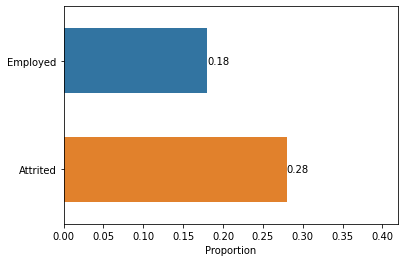

In [5]:
def freq_travel_test(empl_sample: pd.DataFrame, attr_sample: pd.DataFrame) -> None:
    
    def _freq_trav_obs(sample: pd.DataFrame) -> int:
        sr = sample['BusinessTravel']
        freq_sr = sr[sr == 'Travel_Frequently']
        return freq_sr.count()
    
    
    empl_obs = _freq_trav_obs(empl_sample)
    attr_obs = _freq_trav_obs(attr_sample)
    
    empl_n = empl_sample.shape[0]
    attr_n = attr_sample.shape[0]
    
    empl_p = empl_obs / empl_n
    attr_p = attr_obs / attr_n
    

    dict_ = {
        'pval': [utils.proportions_pval(x1=empl_obs, x2=attr_obs, n1=empl_n, n2=attr_n)],
        "cohen's h": [utils.cohen_h(empl_p, attr_p)],
        'empl_p': [empl_p],
        'attr_p': [attr_p]
    }
    return pd.DataFrame(dict_)


def plot_freq_travel_proportions(freq_trav_results: pd.Series) -> None:
    empl_p = freq_trav_results.at['empl_p']
    attr_p = freq_trav_results.at['attr_p']
    
    data = {'Sample': ['Employed', 'Attrited'], 'Proportion': [empl_p, attr_p]}
    proportions_df = pd.DataFrame(data)
    
    plot = sns.barplot(data=proportions_df, x='Proportion', y='Sample', orient='h', width=0.6)
    for container in plot.containers:
        plot.bar_label(container)
        
    plot.set(ylabel=None)
    
    xlim = empl_p * 1.5 if empl_p > attr_p else attr_p * 1.5
    plot.set_xlim(0, xlim)
    plt.show()


results = utils.run_test(samples(is_employed=True), samples(is_employed=False), func=freq_travel_test)
results = utils.median_(results)

print(results)
plot_freq_travel_proportions(results)

## Attrition by Department


PROPORTIONS
---------------
  Group  Department  Proportion
0  Attr  Cardiology        0.38
1  Attr   Maternity        0.49
2  Attr   Neurology        0.14
3  Empl  Cardiology        0.31
4  Empl   Maternity        0.47
5  Empl   Neurology        0.21 


SIGNIFICANCE
---------------
Cardiology pval: 0.933
Cardiology Cohen's h: 0.147

Maternity pval: 0.984
Maternity Cohen's h: 0.04

Neurology pval: 0.906
Neurology Cohen's h: 0.185


CHART
---------------


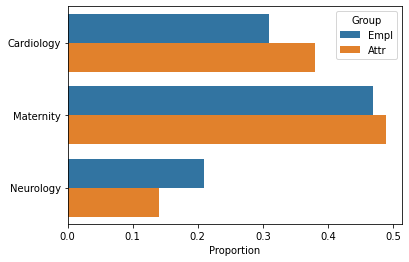

In [6]:
group_str = 'Group'
dept_str = 'Department'
prop_str = 'Proportion'


def gather_dept_proportions(empl_sample: pd.DataFrame, attr_sample: pd.DataFrame) -> pd.DataFrame:
    
    def _calc_proportions(sample: pd.DataFrame, *, is_empl_sample: bool) -> pd.DataFrame:
        '''
        Counts observations and calculates proportions by department. 

        @param:
            sample (pd.DataFrame): independent sample

        @returns:
            pd.DataFrame: a DataFrame with proportions of observations. Columns are Group, Department, Proportion.
        '''
        dept_sr = sample[dept_str]
        
        values_df = dept_sr.value_counts().to_frame().reset_index()
        values_df = values_df.rename(columns={dept_str: 'Count', 'index': dept_str})

        col1 = group_str
        col2 = dept_str
        col3 = prop_str
        df = pd.DataFrame(columns=[col1, col2, col3])
        
        n = sample.shape[0]
        group = 'Empl' if is_empl_sample else 'Attr'
        for row in values_df.itertuples():
            proportion = row.Count / n
            
            new_row = {
                col1: [group], 
                col2: [row.Department], 
                col3: [proportion]
            }
            df = pd.concat([df, pd.DataFrame(new_row)])
        return df
    
    
    empl_df = _calc_proportions(empl_sample, is_empl_sample=True)
    attr_df = _calc_proportions(attr_sample, is_empl_sample=False)
    
    return pd.concat([empl_df, attr_df]).reset_index(drop=True)


def dept_proportions(func: Callable, empl_samples: List, attr_samples: List) -> None:
    p_df = utils.run_test(empl_samples, attr_samples, func=func)
    p_df = p_df.groupby([group_str, dept_str], as_index=False).median()
    return p_df
    
    
def test_dept_significance(results_df: pd.DataFrame, n: int) -> None:
    departments = results_df[dept_str].drop_duplicates()
    
    print(utils.create_title('significance'))
    
    for dept in departments:
        p = results_df[results_df[dept_str] == dept][prop_str].tolist()
        
        pval = utils.proportions_pval(x1=p[0], n1=n, x2=p[1], n2=n)
        h = utils.cohen_h(p[0], p[1])
        
        print(f'{dept} pval: {round(pval, 3)}')
        print(f'{dept} Cohen\'s h: {round(h, 3)}\n')

        
def plot_dept_proportions(results_df: pd.DataFrame) -> None:
    print(utils.create_title('chart'))
    
    order = ['Empl', 'Attr']
    plot = sns.barplot(data=results_df, x=prop_str, y=dept_str, hue=group_str,
                       orient='h', hue_order=order)
    plot.set(ylabel=None)
    plt.show()
    
    
dept_proportions_df = dept_proportions(gather_dept_proportions, samples(is_employed=True), samples(is_employed=False))

print(utils.create_title('proportions'))
print(dept_proportions_df, '\n')

test_dept_significance(dept_proportions_df, sample_size) # TODO: Fix sample size issue. I want a more accurate size.
plot_dept_proportions(dept_proportions_df)

## Attrition by Commute

In [7]:
commute_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='DistanceFromHome')


print(utils.median_(commute_df))
# Todo: plot

pval                 0.020
cohens_d             0.329
ci_68_lower          1.000
ci_68_upper         17.000
empl_p_within_ci     0.810
attr_p_within_ci     0.690
empl_mean            8.000
attr_mean           11.000
dtype: float64


## Attrition by Gender

In [8]:
empl_g_sample = samples(is_employed=True)[0]['Gender']
attr_g_sample = samples(is_employed=False)[0]['Gender']

def test_gender_significance(sr: pd.DataFrame, sr2: pd.Series, n: int) -> None:
    genders = ['Male', 'Female']
    
    print(utils.create_title('significance'))
    
    for gender in genders:
        print(gender)
        x1 = sr.at[gender]
        x2 = sr2.at[gender]
        p1 = x1/n
        p2 = x2/n
        print(x1, x2)
        pval = utils.proportions_pval(x1=x1, n1=n, x2=x2, n2=n)
        h = utils.cohen_h(p1, p2)
        
        print(f'{gender} pval: {round(pval, 3)}')
        print(f' Cohen\'s h: {round(h, 3)}\n')

        
emplvcounts = empl_g_sample.value_counts()
attrvcounts = attr_g_sample.value_counts()
print(emplvcounts, '\n', attrvcounts)

test_gender_significance(emplvcounts, attrvcounts, sample_size)
# TODO: There is always the same difference between obs for both male & female. Figure out why.
# TODO: Create Plot
# TODO: Run test 21 times

Male      58
Female    42
Name: Gender, dtype: int64 
 Male      59
Female    41
Name: Gender, dtype: int64

SIGNIFICANCE
---------------
Male
58 59
Male pval: 0.886
 Cohen's h: 0.02

Female
42 41
Female pval: 0.886
 Cohen's h: 0.02



## Attrition by Hourly Rate

In [9]:
hourlyrate_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='HourlyRate')


print(utils.median_(hourlyrate_df))
# Todo: plot

pval                 0.300
cohens_d             0.147
ci_68_lower         44.000
ci_68_upper         82.000
empl_p_within_ci     0.570
attr_p_within_ci     0.620
empl_mean           66.000
attr_mean           62.000
dtype: float64


## Attrition by Tenure

In [10]:
tenure_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='YearsAtCompany')


print(utils.median_(tenure_df))
# Todo: plot

pval                0.000
cohens_d            0.731
ci_68_lower         0.000
ci_68_upper         8.000
empl_p_within_ci    0.660
attr_p_within_ci    0.890
empl_mean           7.000
attr_mean           3.000
dtype: float64


## Attrition by YearsSinceLastPromotion

In [11]:
promotion_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='YearsSinceLastPromotion')


print(utils.median_(promotion_df))
# Todo: plot

pval                0.027
cohens_d            0.313
ci_68_lower         0.000
ci_68_upper         4.000
empl_p_within_ci    0.830
attr_p_within_ci    0.900
empl_mean           2.000
attr_mean           1.000
dtype: float64


## Attrition by Management

In [12]:
mgmt_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='YearsWithCurrManager')


print(utils.median_(mgmt_df))
# Todo: plot

pval                0.00
cohens_d            0.70
ci_68_lower         0.00
ci_68_upper         5.00
empl_p_within_ci    0.60
attr_p_within_ci    0.83
empl_mean           4.00
attr_mean           2.00
dtype: float64
